# Домашнее задание №5

### Тема: линейные модели и честный ML-эксперимент (логистическая регрессия, бейзлайн, метрики).

1. Загрузка данных и первичный анализ

- импорт необходимый библиотек и модулей

In [1]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Воспроизводимость
RANDOM_STATE = 42

# Библиотеки sklearn для данных, моделей, разбиения и метрик
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV

- загрузка датасета

In [2]:
data = pd.read_csv('S05-hw-dataset.csv')

- первичный анализ

In [3]:
print("Форма X:", data.shape)
print("Названия признаков:", list(data.columns)[:-1])

display(data.head()) # первые строки датасета

Форма X: (3000, 17)
Названия признаков: ['client_id', 'age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
data.info() # информация о столбцах и типах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [5]:
data.describe() # базовые описательные статистики для числовых признаков

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [6]:
data.isna().mean() # доля пропусков в каждом столбце

client_id                         0.0
age                               0.0
income                            0.0
years_employed                    0.0
credit_score                      0.0
debt_to_income                    0.0
num_credit_cards                  0.0
num_late_payments                 0.0
has_mortgage                      0.0
has_car_loan                      0.0
savings_balance                   0.0
checking_balance                  0.0
region_risk_score                 0.0
phone_calls_to_support_last_3m    0.0
active_loans                      0.0
customer_tenure_years             0.0
default                           0.0
dtype: float64

In [7]:
data.duplicated().value_counts(normalize=True) # проерка наличия полностью дублирующих строк

False    1.0
Name: proportion, dtype: float64

In [8]:
data.default.value_counts(normalize=True) # распределение целевого признака default

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

- зафиксированные наблюдения

В данном датасете выявлено 3000 объектов, 16 признаков. Явных аномалий не обнаружено. Пропущенных значений также не обнаружено. Полностью дублирующих строк не обнаружено.

Таргет распределен в соотношении 59 к 41, задача не идеально сбалансирована, но и не экстремально перекошена.

2. Подготовка признаков и таргета

In [9]:
X = data.iloc[:, 1:-1]       # матрица признаков
display(X.head())
y = data.default     # таргет default: (0/1)
display(y.head())

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


0    0
1    0
2    0
3    1
4    1
Name: default, dtype: int64

3. Train/Test-сплит

In [10]:
# Отделяем тестовую выборку (20% данных)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))
print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (2400, 15)
  test:  (600, 15)

Распределение классов (train):
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


4. Бейзлайн-модель на основе DummyClassifier

In [11]:
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Оцениваем на test
y_test_pred_baseline = baseline.predict(X_train)
y_test_proba_baseline = baseline.predict_proba(X_train)[:, 1]

print("Бейзлайн (DummyClassifier, most_frequent) – качество на test")
print("Accuracy :", accuracy_score(y_train, y_test_pred_baseline))
print("Precision:", precision_score(y_train, y_test_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_train, y_test_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_train, y_test_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_train, y_test_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

Бейзлайн (DummyClassifier, most_frequent) – качество на test
Accuracy : 0.5895833333333333
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


DummyClassifier(strategy="most_frequent") всегда предсказывает самый частый класс из train, в нашем случае это всегда 0.

DummyClassifier почти не использует информацию из признаков.

Бейзлайн дает нижнюю планку качества, любая "нормальная" модель должна быть лучше бейзлайна.

5. Логистическая регрессия

In [12]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,
                solver="liblinear",
                random_state=RANDOM_STATE,
                max_iter=1000
            ),
        ),
    ]
)

# Обучаем pipeline на train
log_reg_pipeline.fit(X_train, y_train)

# Предсказываем на test
y_test_pred = log_reg_pipeline.predict(X_test)
y_test_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Логистическая регрессия (C=1.0) – качество на train")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_pred))

print("\nПодробный отчёт по классам:")
print(classification_report(y_test, y_test_pred))

Логистическая регрессия (C=1.0) – качество на train
Accuracy : 0.8
Precision: 0.794392523364486
Recall   : 0.6910569105691057
F1-score : 0.7391304347826086
ROC-AUC  : 0.7833815626291856

Подробный отчёт по классам:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       354
           1       0.79      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600



C:\Users\user\Desktop\уник\5сем\kuznetsova-ms-aie\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


6. Подбор параметра регуляризации C

In [13]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# GridSearchCV будет:
# - внутри делать кросс-валидацию по train
# - выбирать лучший C по заданной метрике (например, ROC-AUC).
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 10.0}
Лучший ROC-AUC (по CV): 0.8606805259098491


C:\Users\user\Desktop\уник\5сем\kuznetsova-ms-aie\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


7. Оцена качества лучшей модели

In [14]:
# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# Оцениваем на test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Лучшая модель – качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

print("\nПодробный отчет по классам (test):")
print(classification_report(y_test, y_test_pred))

Лучшая модель – качество на test
Accuracy : 0.8
Precision: 0.794392523364486
Recall   : 0.6910569105691057
F1-score : 0.7391304347826086
ROC-AUC  : 0.875660282026549

Подробный отчет по классам (test):
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       354
           1       0.79      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600



8. Построение графиков
- ROC-кривая

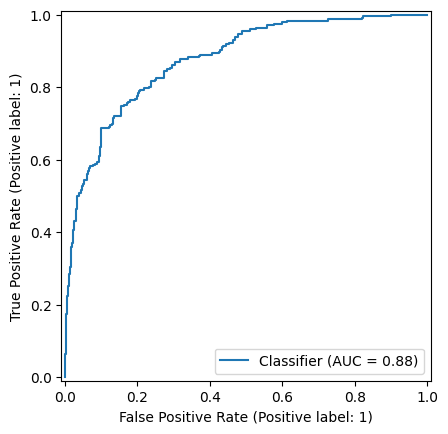

In [15]:
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
)
plt.savefig('figures/roc_curve.png')

- PR-кривая

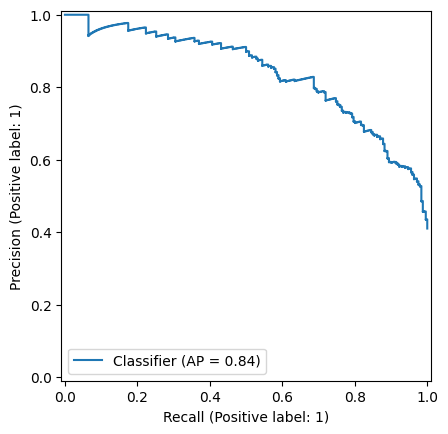

In [16]:
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
)
plt.savefig('figures/pr_curve.png')

9. Сравнение бейзлайна и логистической регрессии, текстовые выводы

In [17]:
comparison_df = pd.DataFrame({
    'Модель': ['Dummy', 'LogReg'],
    'Accuracy': [accuracy_score(y_train, y_test_pred_baseline), accuracy_score(y_test, y_test_pred)],
    'Precision': [precision_score(y_train, y_test_pred_baseline, zero_division=0), precision_score(y_test, y_test_pred, zero_division=0)],
    'Recall': [recall_score(y_train, y_test_pred_baseline, zero_division=0), recall_score(y_test, y_test_pred, zero_division=0)],
    'F1-score': [f1_score(y_train, y_test_pred_baseline, zero_division=0), f1_score(y_test, y_test_pred, zero_division=0)],
    'ROC-AUC': [roc_auc_score(y_train, y_test_proba_baseline), roc_auc_score(y_test, y_test_proba)]
})
print("Таблица сравнения моделей:")
print(comparison_df.round(4))

Таблица сравнения моделей:
   Модель  Accuracy  Precision  Recall  F1-score  ROC-AUC
0   Dummy    0.5896     0.0000  0.0000    0.0000   0.5000
1  LogReg    0.8000     0.7944  0.6911    0.7391   0.8757


**Вывод**
-
Бейзлайн модель показала предсказуемо низкое качество. Accuracy 58.96% - соответствует доле наиболее часто встречающегося класса в Train (0). Precision, Recall и F1-score равны 0 для положительного класса, так как модель всегда предсказывает только класс 0. ROC-AUC = 0.5 - случайное угадывание.

Логистическая регрессия значительно превзошла бейзлайн. Accuracy улучшился с 58.96% до 80%. ROC-AUC увеличился с 0.5 до 0.8757. Появилась способность предсказывать оба класса, а не только самый частый.

При слабой регуляризации (C=10.0) модель показала наилучший ROC-AUC (0.8757). Увеличение C от 0.01 до 10.0 улучшало качество модели.

Логистическая регрессия является адекватной моделью для данной задачи, существенно превосходя бейзлайн по всем метрикам.